# Umbrella and MBAR

- Debería hacer Umbrella y WHAM

-------------------

In [1]:
import os
from copy import deepcopy
import numpy as np
#import sympy as sy
#import math

import matplotlib.pyplot as plt

import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app

#import openmmtools as mmtools
#from openmmtools import testsystems

#import yank.repex as repex
#import yank.analyze as analyze

#import tempfile

from tqdm import tqdm

plt.style.use("ggplot")

## Creo el sistema

In [2]:
# One particle in 3D
system = mm.System()
mass = 1.0 * unit.amu 
system.addParticle(mass)

0

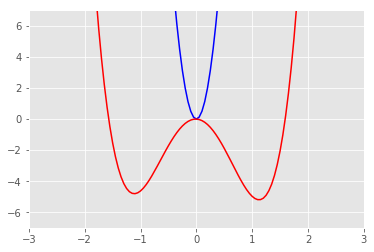

In [3]:
def harmonic_well(x,K):
    # '(1/2)*K*x^2'
    return 0.5*K*x**2

def double_well(x,Eo,C,M):
    # 'Eo(C*x^4-x^2)+M*x'
    return Eo*(C*x**4-x**2)+M*x


K=100.0
Eo=8.0
C=0.4
M=-0.175

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, harmonic_well(x_serie,K), 'b-')
plt.plot(x_serie, double_well(x_serie,Eo,C,M), 'r-')
plt.ylim(-7,7)
plt.xlim(-3,3)
plt.show()

In [4]:
## Adding potential to the system

In [5]:
K  = K  * unit.kilocalories_per_mole/unit.angstrom**2
Eo = Eo * unit.kilocalories_per_mole/unit.angstrom**2
C  = C  * 1/unit.angstrom**2
M  = M  * unit.kilocalories_per_mole/unit.angstrom

force = mm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')
force.addGlobalParameter('K', K)
force.addGlobalParameter('Eo', Eo)
force.addGlobalParameter('C', C)
force.addGlobalParameter('M', M)
force.addParticle(0, [])
system.addForce(force)

0

In [6]:
## Initial Conditions

In [7]:
position_minimum=np.array([1.1,0.0,0.0],dtype=float)
initial_positions = unit.Quantity(position_minimum, unit.angstroms)
#initial_velocitiies will be randomly generated according to temperature by function:
#context.setVelocitiesToTemperature(temperature)

In [8]:
## Adding the Umbrella Potential

In [9]:
Ku  = 100.0 * unit.kilocalories_per_mole/unit.angstrom**2
xu  = 1.1 * unit.angstrom

umbrella = mm.CustomExternalForce('(Ku/2.0)*(x-xu)^2')
umbrella.addGlobalParameter('Ku', Ku)
umbrella.addGlobalParameter('xu', xu)
umbrella.addParticle(0, [])
system.addForce(umbrella)

1

In [10]:
## Umbrella replicas options

In [11]:
lim_inf_us = -1.8
lim_sup_us = 1.8
nus = 24
xus=np.linspace(lim_inf_us, lim_sup_us, nus)
Kus=np.repeat(100.0,nus)

In [12]:
## replica md options

In [13]:
step_size       = 0.002*unit.picoseconds
num_steps       = 20000
saving_period   = 20
num_checks      = int(num_steps/saving_period)

kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin

friction    = 5/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [14]:
platform_name='CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)


#kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA

In [15]:
## thermodynamic states definition

In [16]:
contexts= []

for Ku, xu in zip(Kus,xus):
    context = mm.Context(system, deepcopy(integrator), platform)
    init_position=unit.Quantity(np.array([[xu,0.0,0.0]],dtype=float), unit.angstroms)
    context.setPositions(init_position)
    context.setVelocitiesToTemperature(temperature)
    context.setParameter('Ku', Ku* unit.kilocalories_per_mole/unit.angstrom**2)
    context.setParameter('xu', xu*unit.angstrom)
    contexts.append(context)


In [17]:
## Output arrays and reporters

In [18]:
times     = []
positions = []
velocities = []
potential_energies = []
kinetic_energies = []

for _ in range(nus):
    times.append(unit.Quantity(np.zeros([num_checks], np.float32), unit.picoseconds))
    positions.append(unit.Quantity(np.zeros([num_checks,3], np.float32), unit.angstroms))
    velocities.append(unit.Quantity(np.zeros([num_checks,3], np.float32), unit.angstroms/unit.picosecond))
    potential_energies.append(unit.Quantity(np.zeros([num_checks], np.float32), unit.kilocalories_per_mole))
    kinetic_energies.append(unit.Quantity(np.zeros([num_checks], np.float32), unit.kilocalories_per_mole))

In [19]:
## Platform running

In [20]:
#platform_name='CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
## for ii in range(mm.Platform.getNumPlatforms()):
##     print(mm.Platform.getPlatform(ii).getName())
#platform = mm.Platform.getPlatformByName(platform_name)

In [21]:
#positions_u

In [22]:
## Running Simulations

for u_index in tqdm(range(nus)):
    
    times_u              = times[u_index]
    positions_u          = positions[u_index]
    velocities_u         = velocities[u_index]
    kinetic_energies_u   = kinetic_energies[u_index]
    potential_energies_u = potential_energies[u_index]
    integrator_u = mm.LangevinIntegrator(temperature, friction, step_size)
    
    context = contexts[u_index]
    
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times_u[0] = state.getTime()
    positions_u[0] = state.getPositions()[0]
    velocities_u[0] = state.getVelocities()[0]
    kinetic_energies_u[0]=state.getKineticEnergy()
    potential_energies_u[0]=state.getPotentialEnergy()
    
    for ii in range(num_checks):
        context.getIntegrator().step(saving_period)
        state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
        times_u[ii] = state.getTime()
        positions_u[ii] = state.getPositions()[0]
        velocities_u[ii] = state.getVelocities()[0]
        kinetic_energies_u[ii]=state.getKineticEnergy()
        potential_energies_u[ii]=state.getPotentialEnergy()

100%|██████████| 24/24 [01:42<00:00,  4.28s/it]


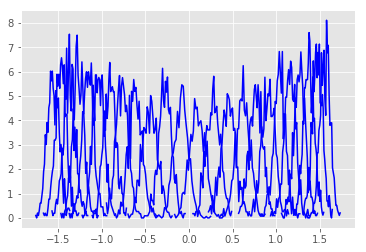

In [23]:
for u_index in range(nus):
    hist, bin_edges = np.histogram(positions[u_index][:,0],bins=40, density=True)
    plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist,'-b')